In [1]:
%matplotlib inline

import os 

import tensorflow as tf
import numpy as np
import keras
import requests

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image

from os import listdir
from os.path import isdir

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import layers
from keras import models
from keras import optimizers
from io import BytesIO

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68606236/68606236 [==============================] - 0s 0us/step


In [3]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats


In [4]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # diretório com fotos de gatos para treinamento
train_dogs_dir = os.path.join(train_dir, 'dogs')  # diretório com fotos de cachorros para treinamento
validation_cats_dir = os.path.join(validation_dir, 'cats')  # diretório com fotos de gatos para validação
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # diretório com fotos de cachorros para validação

In [5]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:5])

train_dog_fnames = os.listdir(train_dogs_dir)
print(train_dog_fnames[:5])

['cat.364.jpg', 'cat.225.jpg', 'cat.524.jpg', 'cat.135.jpg', 'cat.415.jpg']
['dog.612.jpg', 'dog.134.jpg', 'dog.226.jpg', 'dog.193.jpg', 'dog.21.jpg']


In [7]:
print('Total de imagens de gatos para treinamento:     ', len(os.listdir(train_cats_dir)))
print('Total de imagens de cachorros para treinamento: ', len(os.listdir(train_dogs_dir)))
print('Total de imagens de gatos para validação:       ', len(os.listdir(validation_cats_dir)))
print('Total de imagens de cachorros para validação:   ', len(os.listdir(validation_dogs_dir)))

print('\nTotal de imagens para treinamento: ', len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))
print('Total de imagens para validação:   ', len(os.listdir(validation_cats_dir)) + len(os.listdir(validation_dogs_dir)))

Total de imagens de gatos para treinamento:      1000
Total de imagens de cachorros para treinamento:  1000
Total de imagens de gatos para validação:        500
Total de imagens de cachorros para validação:    500

Total de imagens para treinamento:  2000
Total de imagens para validação:    1000


In [8]:
# Parâmetros para o gráfico; as imagens serão geradas em uma configuração 4x4
nrows = 4
ncols = 4

# Índice para iterar imagens
pic_index = 0

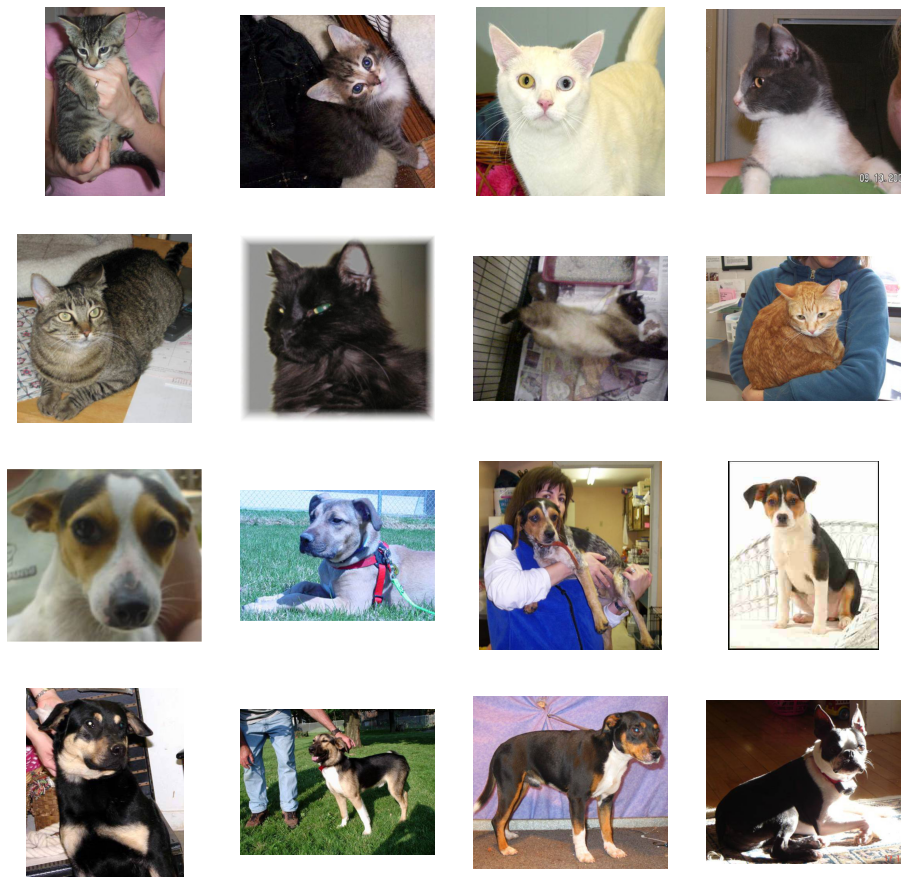

In [9]:
# Configura o matplotlib fig e dimensiona para caber em fotos 4x4
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pic = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pic = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pic + next_dog_pic):
    # Configura subtrama; os índices do subplot começam em 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')  # Não mostrar eixos (ou linhas de grade)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()


In [10]:
filepath = 'transferlearning_weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, node='max')

In [12]:
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.001, patience=5, verbose=1)

In [13]:
callbacks = [checkpoint, lr_reduce]

In [16]:
IMAGE_SIZE = [220, 220]
EPOCHS = 60
CLASSES = 2
BATCH_SIZE = 32
INPUT_SHAPE = (220,220,3)
alpha = 1e-5
random_state = 42

In [14]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

In [17]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)

Found 2000 images belonging to 2 classes.


In [18]:
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)

Found 1000 images belonging to 2 classes.


Transfer Learning

In [19]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

94765736/94765736 [==============================] - 1s 0us/step


In [20]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 220, 220, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 226, 226, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 110, 110, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

Criação e sumarização do modelo:

In [21]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(CLASSES, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 2)                 1

In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=float, momentum=float),
              metrics=['acc'])

Treinamento do modelo e armazenamento do histórico

In [31]:
history = model.fit(train_generator,
                    epochs=3,
                    shuffle=True,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=callbacks)

Epoch 1/3
63/63 [==============================] - ETA: 0s - loss: 0.2227 - acc: 0.9090 
Epoch 1: val_acc improved from 0.50100 to 0.50500, saving model to transferlearning_weights.hdf5
63/63 [==============================] - 1643s 26s/step - loss: 0.2227 - acc: 0.9090 - val_loss: 1.2450 - val_acc: 0.5050 - lr: 1.0000e-04
Epoch 2/3
63/63 [==============================] - ETA: 0s - loss: 0.1805 - acc: 0.9275 
Epoch 2: val_acc improved from 0.50500 to 0.50900, saving model to transferlearning_weights.hdf5
63/63 [==============================] - 1526s 24s/step - loss: 0.1805 - acc: 0.9275 - val_loss: 1.8750 - val_acc: 0.5090 - lr: 1.0000e-04
Epoch 3/3
63/63 [==============================] - ETA: 0s - loss: 0.1577 - acc: 0.9415 
Epoch 3: val_acc improved from 0.50900 to 0.54900, saving model to transferlearning_weights.hdf5
63/63 [==============================] - 1537s 24s/step - loss: 0.1577 - acc: 0.9415 - val_loss: 1.4937 - val_acc: 0.5490 - lr: 1.0000e-04


Salvando o modelo

In [32]:
model.save('cats_and_dogs_filtered.h5')

Acurácia do modelo segundo as EPOCHS

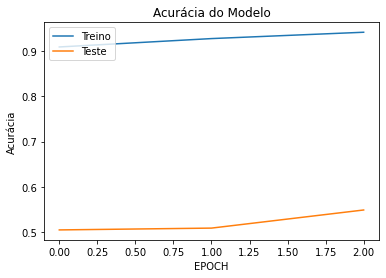

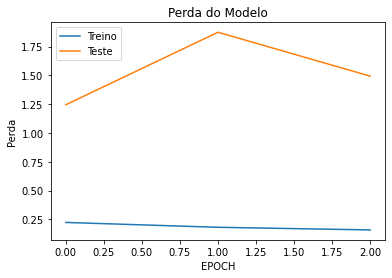

In [33]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Acurácia do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('EPOCH')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

# Sumarização do histórico de perda
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Perda do Modelo')
plt.ylabel('Perda')
plt.xlabel('EPOCH')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

Carregando resultados do teste do modelo

In [34]:
test_images = [
    'https://www.petz.com.br/blog/wp-content/uploads/2019/05/cachorro-independente-1.jpg',
    'https://www.petz.com.br/blog/wp-content/uploads/2019/05/cachorro-independente-2.jpg',
    'https://www.petz.com.br/blog/wp-content/uploads/2022/09/como-socializar-gatos-com-outros-gatos.jpg',
    'https://www.petz.com.br/blog/wp-content/uploads/2022/09/como-socializar-gatos-com-outros-gatos-3.jpg',
    'https://www.petz.com.br/blog/wp-content/uploads/2022/10/cao-mais-perigoso-do-mundo.jpg',
    'https://www.petz.com.br/blog/wp-content/uploads/2022/10/como-dar-banho-em-gato-bravo-2.jpg',
    'https://www.petz.com.br/blog/wp-content/uploads/2022/10/nomes-para-dalmatas.jpg',
    'https://www.petz.com.br/blog/wp-content/uploads/2022/09/linguagem-corporal-do-gato-2.jpg'
]

test_labels = [1, 1, 0, 0, 1, 0, 1, 0]  # 1 --> Cachorro; 0 --> Gato

1/1 [==============================] - 0s 238ms/step


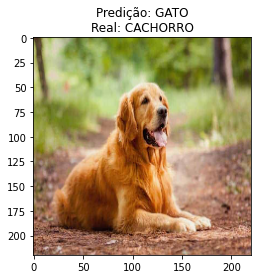

1/1 [==============================] - 0s 197ms/step


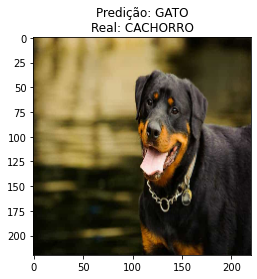

1/1 [==============================] - 0s 191ms/step


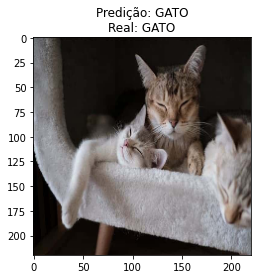

1/1 [==============================] - 0s 201ms/step


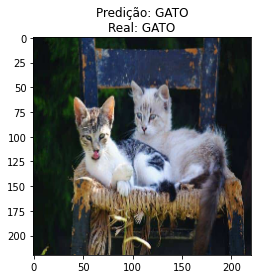

1/1 [==============================] - 0s 225ms/step


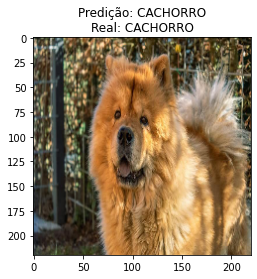

1/1 [==============================] - 0s 200ms/step


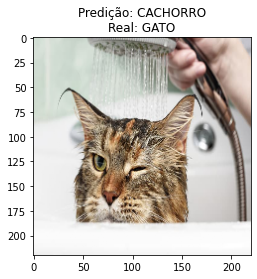

1/1 [==============================] - 0s 200ms/step


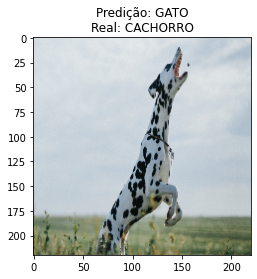

1/1 [==============================] - 0s 202ms/step


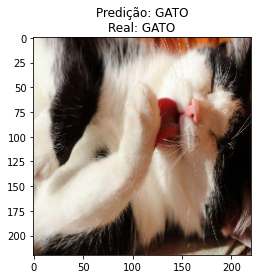

In [35]:
for (i,l) in enumerate(test_labels):
    response = requests.get(test_images[i])
    img = Image.open(BytesIO(response.content))
    img = np.asanyarray(img)/255.
    img = tf.image.resize(img, [IMAGE_SIZE[0], IMAGE_SIZE[1]])
    img = tf.reshape(img, (1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    prediction = model.predict(img)
    output = np.argmax(prediction)

    label = ['GATO', 'CACHORRO']
    plt.title(f'Predição: {label[output]}\nReal: {label[test_labels[i]]}')
    plt.imshow(img[0, ...])
    plt.show()